# Regression

In the previous section, we explored how to classify the subject's actions. While useful, relying solely on a set of predefined states for prediction can be somewhat restrictive. There are scenarios where a more flexible approach to decoding the user's motor intentions is desirable. To address this, we'll shift our focus from classification to regression. The earlier dataset wasn't suitable for regression analysis, so we'll return to using the Ninapro dataset (look at https://ninapro.hevs.ch/instructions/DB2.html). This dataset includes detailed information about finger angles, which you can find at Ninapro Database 2 Instructions. Our objective now is to predict these finger angles using the EMG data from the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt


Run the commented code to download the data (if you haven't already).

In [2]:
# !pip install gdown
# import gdown
# url = "https://drive.google.com/uc?id=1Wjb6YzRPYjutV5o-FEp5jcRl3jv-i8dJ"
# output = "exercise_2_dataset_1.mat"
# gdown.download(url, output, quiet = False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Wjb6YzRPYjutV5o-FEp5jcRl3jv-i8dJ
From (redirected): https://drive.google.com/uc?id=1Wjb6YzRPYjutV5o-FEp5jcRl3jv-i8dJ&confirm=t&uuid=5c0c8f8c-0854-46c3-beac-dbbc0b69851f
To: g:\Shared drives\NX-421-TNE\Week 11\exercise_2_dataset_1.mat
100%|██████████| 1.00G/1.00G [02:10<00:00, 7.69MB/s]


'exercise_2_dataset_1.mat'

In [3]:
data = loadmat("exercise_2_dataset_1.mat")

#Reduce data size for faster training in later stage
EMG = data["emg"][:200000,:] 
glove = data["glove"][:200000,:]
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'emg', 'acc', 'gyro', 'mag', 'glove', 'stimulus', 'repetition', 'restimulus', 'rerepetition'])

Text(0, 0.5, 'Amplitude [V]')

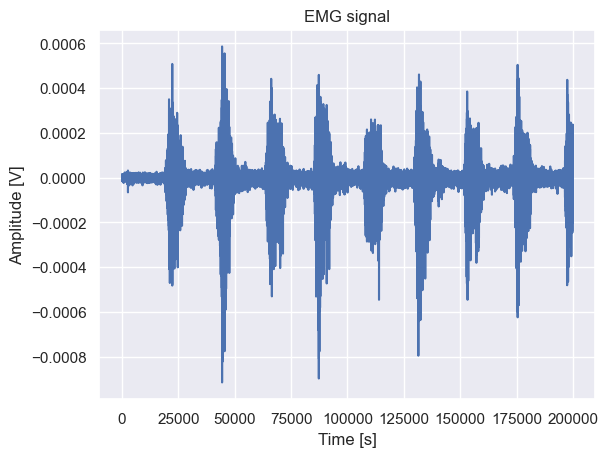

In [4]:
fig, ax = plt.subplots()
ax.plot(EMG[:, 0])
ax.set_title("EMG signal")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude [V]")

We can see when the channel is picking up signals from the muscles. Lets apply the same preprocessing steps to filter and calculate the envelop of the EMG signals.

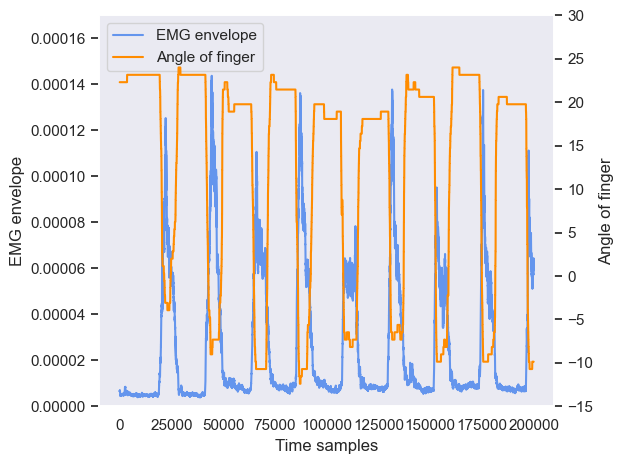

In [5]:
fs = 2000
Wn = (5, 500)
sos = butter(N=4, Wn=Wn, fs=fs, btype="bandpass", output="sos")
EMG_filtered = sosfiltfilt(sos, EMG.T).T

Wns = [n*50 for n in range(1,11)] # removing 50Hz noise and its harmonics

for Wn in Wns:
    sos = butter(N=4, Wn=(Wn - 1, Wn + 1), fs=fs, btype="bandstop", output="sos") 
    EMG_filtered = sosfiltfilt(sos, EMG_filtered.T).T


EMG_rectified = np.abs(EMG_filtered) #full-wave rectification

mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(EMG_rectified, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots()
ax.plot(EMG_envelopes[:, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_ylim([0, 0.00017])  # For first y-axis
ax.set_xlabel("Time samples")
ax.grid(False)

ax2 = ax.twinx()
ax2.plot(glove[:, 2], color="darkorange", label="Angle of finger")
ax2.set_ylabel("Angle of finger")
ax2.set_ylim([-15, 30])  # For second y-axis
ax2.grid(False)

# Get handles and labels for legend
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create a single legend
ax.legend(handles, labels, loc='upper left')
plt.tight_layout()

In [6]:
fs = 2000  # [Hz], from dataset description
window_width_time = 0.1  # [s]
steps = 0.01  # [s]

In [7]:
def cut_datasets(EMG, Labels,val_cut, test_cut):

    """
    This function is defined to cut the data in three sets
    :param EMG: Numpy array containing the data
    :param Targets: Numpy array containing the targets
    :param val_cut: information on how/where to cut the dataset to obtain the validation set
    :param test_cut: information on how/where to cut the dataset to obtain the test set
    :return: 6 pandas DataFrames (or numpy arrays) containing EMG and Labels of each sets
    """
    
    ###########################################
    ################## TODO ###################
    ###########################################

    EMG_train = EMG[:val_cut]
    EMG_val = EMG[val_cut:test_cut]
    EMG_test = EMG[test_cut:]
    Labels_train = Labels[:val_cut]
    Labels_val = Labels[val_cut:test_cut]
    Labels_test = Labels[test_cut:]


    return EMG_train, EMG_val, EMG_test, Labels_train, Labels_val, Labels_test

def extract_time_windows_regression(EMG,Label, fs,win_len,step):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Targets: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)
    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The length of both outputs should be the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [8]:
val_cut = int(len(EMG_envelopes)*0.7) 
test_cut = int(len(glove)*0.7) #In this example we will not be using a validation set, hence we set it to 0.7 as well


EMG_train, EMG_val, EMG_test, Labels_train, Labels_val, Labels_test = cut_datasets(EMG_envelopes, glove, val_cut, test_cut)

In [9]:
EMG_train_window, Labels_train_window = extract_time_windows_regression(EMG_train,Labels_train, fs, window_width_time, steps)
# EMG_train_window.shape,Labels_train_window.shape

EMG_val_window, Labels_val_window = extract_time_windows_regression(EMG_val,Labels_val, fs, window_width_time, steps)
# EMG_val_window.shape,Labels_val_window.shape

EMG_test_window, Labels_test_window = extract_time_windows_regression(EMG_test,Labels_test, fs, window_width_time, steps)
EMG_test_window.shape,Labels_test_window.shape

((2990, 200, 16), (2990, 200, 18))

Now that we have the windows, lets extract some features again. For this exercise, we will just look at the mean and std of the windows.

In [10]:
def extract_mean_std(EMG_windows,Labels_windows):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    
    ###########################################
    ################## TODO ###################
    ###########################################
    
    EMG_mean = np.mean(EMG_windows,axis=1)
    EMG_std = np.std(EMG_windows,axis=1)
    Labels_mean = np.mean(Labels_windows,axis=1)
    
    # Concatenate the mean and std of each window
    EMG_mean_std = np.concatenate((EMG_mean, EMG_std), axis=1)
    return EMG_mean_std, Labels_mean

In [11]:
EMG_train_mean_std, Labels_train_mean = extract_mean_std(EMG_train_window,Labels_train_window)
EMG_val_mean_std, Labels_val_mean = extract_mean_std(EMG_val_window,Labels_val_window)
EMG_test_mean_std, Labels_test_mean = extract_mean_std(EMG_test_window,Labels_test_window)

EMG_train_mean_std.shape, Labels_train_mean.shape

((6990, 32), (6990, 18))

Next, we'll focus on the regressor. Scikit-learn greatly simplifies the process, whether you're working with classification or regression tasks. The key is ensuring your data is in a format compatible with the library. Once that's achieved, switching between different algorithm types to suit your data becomes straightforward. The workflow is quite similar across various algorithms: you start by fitting the model to your training data, and then proceed to make predictions on the test set.

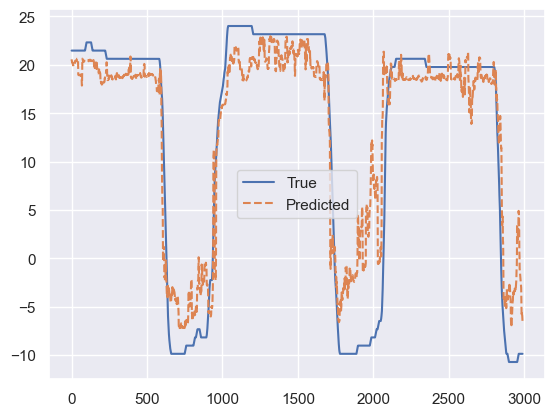

In [12]:
from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor() #you're free to use any regressor that you like.
regressor.fit(EMG_train_mean_std, Labels_train_mean[:,2])

y_pred = regressor.predict(EMG_test_mean_std)
fig, ax = plt.subplots()
ax.plot(Labels_test_mean[:,2], label="True")
ax.plot(y_pred, linestyle="--", label="Predicted")
ax.legend()

It seems that just using the random forest regressor is sufficient to predict the angles of the finger. Nonetheless, it's crucial to quantify the model's performance using appropriate metrics. Take a look at scikit-learn's model evaluation (https://scikit-learn.org/stable/modules/model_evaluation.html), there are many metrics that we can choose. The more common ones are MSE, RMSE, MAE. For this exercise, we can take a look at MSE. 

In [13]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Labels_test_mean[:,2], y_pred)

24.690557133564575

By itself, the values might not seem that meaningful (if you're very familiar with the domain of your analysis, you might get a sensing of how good the MSE is). Unlike classification's accuracy, regression usually require more context or comparison. Let's try to compare 3 different algorithm and evaluate the MSE.

In [14]:
import sklearn 

linear_regressor = sklearn.linear_model.LinearRegression() #you're free to use any regressor that you like.
linear_regressor.fit(EMG_train_mean_std, Labels_train_mean[:,2])

y_pred_linear = linear_regressor.predict(EMG_test_mean_std)


SVR_regressor = sklearn.svm.SVR()
SVR_regressor.fit(EMG_train_mean_std, Labels_train_mean[:,2])

y_pred_SVR = SVR_regressor.predict(EMG_test_mean_std)

MSE_RF = mean_squared_error(Labels_test_mean[:,2], y_pred)
MSE_linear = mean_squared_error(Labels_test_mean[:,2], y_pred_linear)
MSE_SVR = mean_squared_error(Labels_test_mean[:,2], y_pred_SVR)

# print(MSE_RF, MSE_linear, MSE_SVR)

print(f'MSE of Random Forest: {MSE_RF}')
print(f'MSE of Linear Regression: {MSE_linear}')
print(f'MSE of SVR: {MSE_SVR}')

MSE of Random Forest: 24.690557133564575
MSE of Linear Regression: 28.771053000617776
MSE of SVR: 23.146534760387812


Which model performs best?
Was the result of this comparison expected?